In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     Flatten, Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!pip install --upgrade kaggle
!kaggle --version


Kaggle API 1.7.4.2


In [10]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [11]:
def get_class_paths(base_path):
    classes, paths = [], []
    for label in os.listdir(base_path):
        full_dir = os.path.join(base_path, label)
        if os.path.isdir(full_dir):
            for fname in os.listdir(full_dir):
                classes.append(label)
                paths.append(os.path.join(full_dir, fname))
    return pd.DataFrame({"Class": classes, "Path": paths})

tr_df = get_class_paths("Training")
ts_df = get_class_paths("Testing")

In [12]:
#Split Testing into validation & test 50/50
valid_df, ts_df = train_test_split(
    ts_df, stratify=ts_df["Class"], train_size=0.5, random_state=42
)
#RANDOM STATE Sets a seed for reproducibility
#ensuring that the split is consistent across different runs
#every time run the code
# the data will be split in the same way ensuring consistency in result
batch_size = 16
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))
test_datagen  = ImageDataGenerator(rescale=1/255)

tr_gen = train_datagen.flow_from_dataframe(
    tr_df, x_col="Path", y_col="Class",
    target_size=img_size, batch_size=batch_size
)
valid_gen = train_datagen.flow_from_dataframe(
    valid_df, x_col="Path", y_col="Class",
    target_size=img_size, batch_size=batch_size
)
ts_gen = test_datagen.flow_from_dataframe(
    ts_df, x_col="Path", y_col="Class",
    target_size=img_size, batch_size=batch_size, shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [13]:
#VGG‑19 Architecture

inputs = Input(shape=(224, 224, 3))

# Block 1 (2 Conv64 + Pool)
x = Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), strides=2)(x)

# Block 2 (2 Conv128 + Pool)
x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), strides=2)(x)

# Block 3 (4 Conv256 + Pool)
for _ in range(4):
    x = Conv2D(256, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), strides=2)(x)

# Block 4 (4 Conv512 + Pool)
for _ in range(4):
    x = Conv2D(512, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), strides=2)(x)

# Block 5 (4 Conv512 + Pool)
for _ in range(4):
    x = Conv2D(512, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D((2,2), strides=2)(x)



In [14]:
# flatten layer
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x) #Stacking dense layers enables the model to learn higher-level representations.​


outputs = Dense(len(tr_gen.class_indices), activation="softmax")(x)

model = Model(inputs, outputs, name="VGG19_Custom")
model.compile(
    optimizer=Adam(learning_rate=1e-4),#computes adaptive learning rates for each parameter by considering both the first-order momentum and second-order acceleration of the gradients.
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "VGG19_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,31

 Total params: 139,586,628 (532.48 MB)

 Trainable params: 139,586,628 (532.48 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Train model

early_stop  = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
#EarlyStopping Callback set to monitor the val_loss if the validation loss doesn't improve for 3 epochs training will stop early.
reduce_lr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

history = model.fit(
    tr_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 182s 400ms/step - accuracy: 0.4367 - loss: 1.1712 - val_accuracy: 0.6901 - val_loss: 0.7312 - learning_rate: 1.0000e-04
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 129s 361ms/step - accuracy: 0.7414 - loss: 0.6064 - val_accuracy: 0.7603 - val_loss: 0.6159 - learning_rate: 1.0000e-04
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 129s 361ms/step - accuracy: 0.7981 - loss: 0.4822 - val_accuracy: 0.8061 - val_loss: 0.4630 - learning_rate: 1.0000e-04
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 129s 361ms/step - accuracy: 0.8532 - loss: 0.3793 - val_accuracy: 0.8275 - val_loss: 0.4272 - learning_rate: 1.0000e-04
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 361ms/step - accuracy: 0.8897 - loss: 0.2988 - val_accuracy: 0.8412 - val_loss: 0.3995 - learning_rate: 1.0000e-04
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 129s 360ms/step - accuracy: 0.9116 - loss: 0.2332 - val_accuracy: 0.8809 - val_loss: 0.2960 - learning_rate: 1.0000e-04
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 

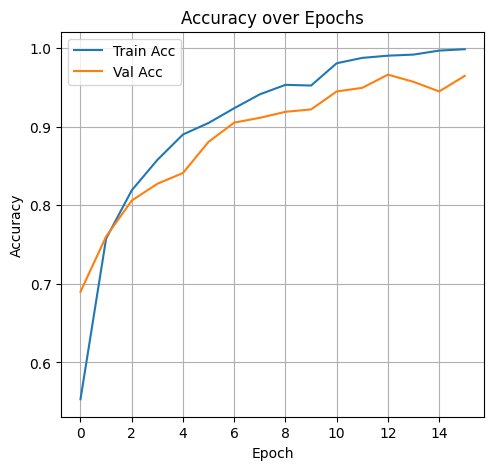

In [16]:
# Plot accuracy loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)



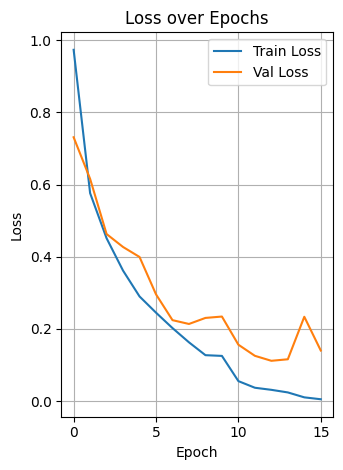

In [17]:
# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

model.save("vgg19_brain_tumor_mri.h5")


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step


<Figure size 700x600 with 0 Axes>

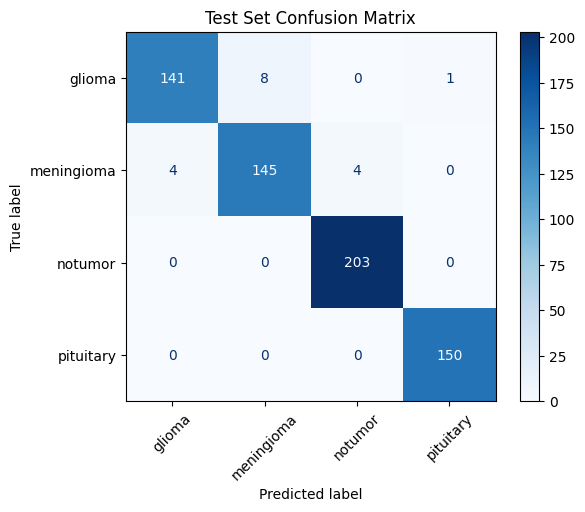

Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.94      0.96       150
  meningioma       0.95      0.95      0.95       153
     notumor       0.98      1.00      0.99       203
   pituitary       0.99      1.00      1.00       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [18]:
# Evaluate on test set

# predictions
y_true = ts_gen.classes
y_pred = np.argmax(model.predict(ts_gen), axis=1)

# confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(tr_gen.class_indices.keys()))

plt.figure(figsize=(7,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Test Set Confusion Matrix")
plt.grid(False)
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(tr_gen.class_indices.keys())))


In [18]:
#DISCUSSION
The role of each layer in the architecture
Input layer: Accepts images of size 224×224×3
 CONV LAYER:3×3 filters to the input image, detecting various features such as edges, textures and patterns.The use of small filters allows the network to capture details while maintaining computational efficiencY
ReLU activation: After each convolutional operation ReLU activation function introduces non linearity and  network can learn complex patterns and representations
Max pool:Max pooling involves sliding a fixed-size window 2x2 over the input feature map and selecting the maximum value within each window. This process results in a downsampled feature map that retains the most prominent features  discard less significant details.
Fully connected layer: At the end of the network fully connected layers integrate the features extracted by the convolutional layers to make final classification decisions. The dense connections allow the network to combine features from all regions of the image.​
Softmax layer:Softmax layer outputs a probability distribution over the possible classes assigning a likelihood to each class and facilitating multi-class classification.​



Why VGG-19 uses small filters (3×3) [1]
Small filters allow the network to capture detailed spatial hierarchies in images, enable to to learn complex patterns effectively.